 This notebook generates a single batch of experiment 3 under the generative model. Note that theses simulations will not exactly match the simulations in the paper, as they were drawn from a larger, boostrapped, sample.

In [1]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# custom libraries used
from models.grid_world import Experiment
from models.agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent, MetaAgent
from models.experiment_designs.experiment1 import gen_task_param
sns.set_context('paper', font_scale=1.5)
print sns.__version__

0.9.0


In [2]:
n_sims = 115

# alpha is sample from the distribution
# log(alpha) ~ N(alpha_mu, alpha_scale)
alpha_mu = -0.5
alpha_scale = 1.0

inv_temp = 10.0
goal_prior = 1e-10 
mapping_prior = 1e-10
pruning_threshold = 500.0
evaluate = False

np.random.seed(0)

# pre generate a set of tasks for consistency. 
list_tasks = [gen_task_param() for _ in range(n_sims)]

# pre draw the alphas for consistency
list_alpha = [np.exp(scipy.random.normal(loc=alpha_mu, scale=alpha_scale)) 
              for _ in range(n_sims)]

def sim_agent(AgentClass, name='None', flat=False, meta=False):
    results = []
    for ii, (task_args, task_kwargs) in tqdm(enumerate(list_tasks), total=len(list_tasks)):

        if not flat:
            agent_kwargs = dict(alpha=list_alpha[ii], inv_temp=inv_temp, mapping_prior=mapping_prior,
                                goal_prior=goal_prior)
        else:
            agent_kwargs = dict(inv_temp=inv_temp, goal_prior=goal_prior, mapping_prior=mapping_prior)
            
        if meta:
            p = np.random.uniform(0, 1)
            agent_kwargs['mix_biases'] = [np.log(p), np.log(1-p)]
            agent_kwargs['update_new_c_only'] = True

        agent = AgentClass(Experiment(*task_args, **task_kwargs), **agent_kwargs)
        
        _res = agent.generate(evaluate=evaluate, pruning_threshold=pruning_threshold)
        _res[u'Model'] = name
        _res[u'Iteration'] = [ii] * len(_res)
        results.append(_res)
    return pd.concat(results)

In [3]:
results_ic = sim_agent(IndependentClusterAgent, name='Independent')
results_jc = sim_agent(JointClusteringAgent, name='Joint')
results_fl = sim_agent(FlatAgent, name='Flat', flat=True)
results_meta = sim_agent(MetaAgent, name='Meta', meta=True)
results = pd.concat([results_ic, results_jc, results_fl, results_meta])

100%|██████████| 115/115 [05:57<00:00,  3.11s/it]
/anaconda3/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


## Model Predictions
Summary Statistics:

In [4]:
results['Training'] = results.Context < 5
results['Acc'] = pd.to_numeric(results.Reward)
results[results['In Goal']].groupby(['Training', 'Model']).mean()

Context  In Goal  Ind Weight  Ind dWeight  Iteration  \
Training Model                                                                
False    Flat         6.166667     True         NaN          NaN       57.0   
         Independent  6.166667     True         NaN          NaN       57.0   
         Joint        6.166667     True         NaN          NaN       57.0   
         Meta         6.166667     True  -15.484027    -2.743023       57.0   
True     Flat         2.750000     True         NaN          NaN       57.0   
         Independent  2.750000     True         NaN          NaN       57.0   
         Joint        2.750000     True         NaN          NaN       57.0   
         Meta         2.750000     True   -6.508002    -0.656897       57.0   

                      Joint Probability  Joint Weight  Joint dWeight  \
Training Model                                                         
False    Flat                       NaN           NaN            NaN   
         Independent                NaN           NaN            NaN   
         Joint                      NaN           NaN            NaN   
         Meta                  0.323789    -18.413730      -2.838610   
True     Flat                       NaN           NaN            NaN   
         Independent                NaN           NaN            NaN   
         Joint                      NaN           NaN            NaN   
         Meta                  0.397052     -7.703394      -1.757428   

                      Key-press    Reward  Steps Taken  Times Seen Context  \
Training Model                                                               
False    Flat          3.495652  0.858551     6.719130            4.666667   
         Independent   3.482899  0.828406     4.988116            4.666667   
         Joint         3.463188  0.824638     5.441449            4.666667   
         Meta          3.488406  0.828406     5.124638            4.666667   
True     Flat          3.489928  0.954565     5.287971           16.333333   
         Independent   3.485942  0.944058     5.025507           16.333333   
         Joint         3.480507  0.943551     5.143913           16.333333   
         Meta          3.484710  0.945435     5.071884           16.333333   

                      Trial Number       Acc  
Training Model                                
False    Flat                134.5  0.858551  
         Independent         134.5  0.828406  
         Joint               134.5  0.824638  
         Meta                134.5  0.828406  
True     Flat                 59.5  0.954565  
         Independent          59.5  0.944058  
         Joint                59.5  0.943551  
         Meta                 59.5  0.945435

Plot the overall rewards collected in the training and test contexts

/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/envs/compgen/lib/python2.7/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


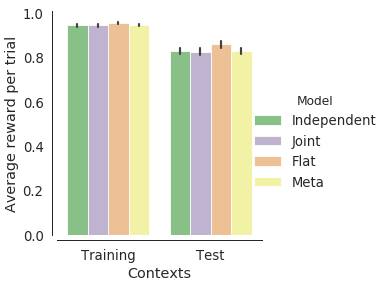

In [5]:
in_goal = results[results['In Goal'] ].copy()
in_goal['Contexts'] = [None] * len(in_goal)
in_goal.loc[in_goal.Context < 5, 'Contexts'] = 'Training'
in_goal.loc[in_goal.Context >= 5, 'Contexts'] = 'Test'

with sns.axes_style('white'):
    g = sns.factorplot(y='Reward', data=in_goal, x='Contexts', 
                   hue='Model', units='Iteration', kind='bar', 
                   estimator=np.mean, palette='Accent', size=4)
    sns.despine(offset=5, trim=False)
    ax = g.axes[0][0]
    ax.set_ylabel('Average reward per trial')

In [6]:
from scipy.stats import ttest_ind

g = results[results['In Goal']].groupby(['Training', 'Model', 'Iteration']).mean()

def print_model_norm(model):
    t, p = ttest_ind(g.loc[(True, 'Flat'),'Acc'], g.loc[(True, model),'Acc'])
    df = len(g.loc[(True, 'Flat'),'Acc']) * 2 -2
    M = g.loc[(True, model),'Acc'].mean() - g.loc[(True,'Flat'),'Acc'].mean()
    print "%s (Train):  M=%.3g, t(%d)=%.5g, p=%.3g" % (model, M, df, t, p)
    
    t, p = ttest_ind(g.loc[(False, 'Flat'),'Acc'], g.loc[(False, model),'Acc'])
    df = len(g.loc[(False, 'Flat'),'Acc']) * 2 -2
    M = g.loc[(False, model),'Acc'].mean() - g.loc[(False,'Flat'),'Acc'].mean()
    print "%s (Test) :  M=%.3g, t(%d)=%.5g, p=%.3g" % (model, M, df, t, p)

print_model_norm('Independent')
print_model_norm('Joint')
print_model_norm('Meta')

Independent (Train):  M=-0.0105, t(228)=3.4669, p=0.000629
Independent (Test) :  M=-0.0301, t(228)=5.0426, p=9.36e-07
Joint (Train):  M=-0.011, t(228)=3.9626, p=9.92e-05
Joint (Test) :  M=-0.0339, t(228)=4.8906, p=1.9e-06
Meta (Train):  M=-0.00913, t(228)=3.1256, p=0.00201
Meta (Test) :  M=-0.0301, t(228)=4.551, p=8.68e-06


Break down the accuracy in each test context

/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


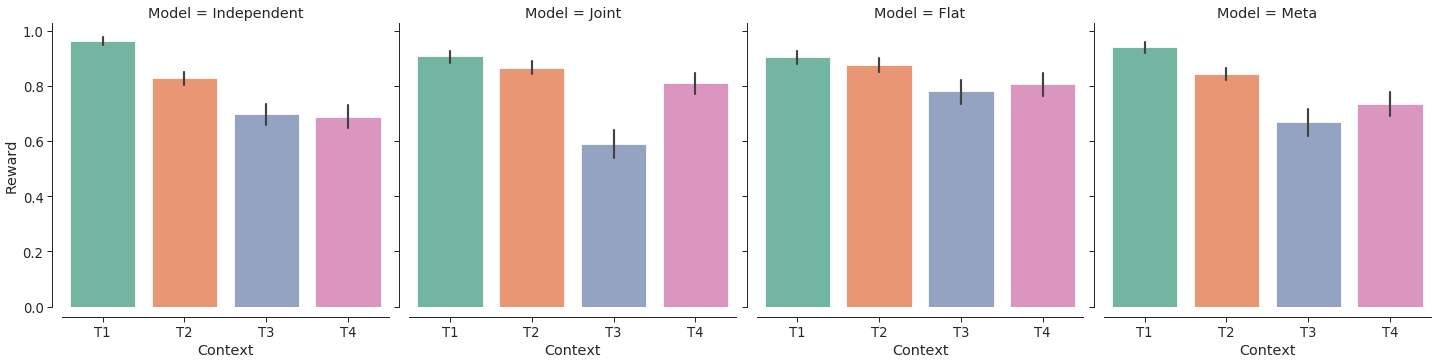

In [7]:
with sns.axes_style('ticks'):
    g = sns.factorplot(x='Context', y='Reward', data=in_goal[in_goal['Contexts'] == 'Test'], 
                   kind='bar', palette='Set2', col='Model', units='Iteration')
    g.set_xticklabels(['T1', 'T2', 'T3', 'T4'])
    sns.despine(offset=10)
    

# Paper Figure
*Left*: Reward collected in test contexts across time

*Right*: Difference in reward collect between contexts across equated trials

In [8]:

### calculate the differences scores for each condition

df0 = results[results['In Goal'] & (results.Context > 4) & (results['Times Seen Context'] <= 5) &
              (results['Model'] != 'Flat')
             ].copy()
score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 5, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[subj_df.Context == 8, :].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 6), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[subj_df.Context == 7, :].groupby('Times Seen Context').mean()['Acc']
            

        diff_3 = subj_df.loc[(subj_df.Context == 5) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 7), :].groupby('Times Seen Context').mean()['Acc']

        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T4'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T2 vs T3'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1/4 vs T2/3'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
score = pd.concat(score) 

# df0 = results[results['In Goal'] & (results.Context >= 4) & 
#               (results['Times Seen Context'] < 6) ].copy()
df0['Context'] += 1
# df0


In [9]:
### define a plotting function to display the test results

from matplotlib import gridspec
from scipy.stats import ttest_1samp

def plot_test_overtime(model_name, ax):
    # plot the results over time
    sns.pointplot(x='Times Seen Context', hue='Context', y='Reward', ci=None,
                  data=df0[df0.Model==model_name],  palette='Set2', ax=ax)

    # plot the collapsed difference scores
    ax.legend_.remove() 
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)

    ax.set_xticklabels([1, 2, 3, 4, 5])
    ax.set_ylabel(r'Accuracy')
    ax.plot([0, 5], [0.25, 0.25], 'k:')
    ax.set_ylim([0, 1])
    ax.set_title(model_name)
    sns.despine(offset=5, ax=ax)
    
def plot_test_difference_score(model_name, ax):
    sns.barplot(x='Comparison', y='Difference Score',
                data=score[score.Model == model_name], color='skyblue', ax=ax)
    ax.set_ylabel(r'Difference Score', labelpad=-3)
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    sns.despine(offset=5, ax=ax)
    plt.sca(ax)
    plt.xticks([0, 1, 2], [r'1 > 4', u'2 > 3', r'1/4 > 2/3' ], rotation='vertical',
               fontsize='small')

    
def print_diff_stats(model_name):
    diff = score.groupby(['Model', 'Comparison','Iteration']).mean().reset_index()
    for c in set(score.Comparison):
        selection = (diff.Model == model_name) &(diff.Comparison == c)
        t, p = ttest_1samp(diff.loc[selection, 'Difference Score'].values, 0)
        df = len(diff.loc[selection, 'Difference Score'].values)
        M = np.mean(diff.loc[selection, 'Difference Score'].values)
        print "%s: M=%.3g, t(%d)=%.5g, p=%.3g" % (c, M, df, t, p)
        
def plot_test(model_name):
    with sns.axes_style('ticks'):
        fig  = plt.figure(figsize=(5.5, 3))
        gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.3)
        axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]

        plot_test_overtime(model_name, ax=axes[0])
        plot_test_difference_score(model_name, ax=axes[1])
        
        print_diff_stats(model_name) 

/anaconda3/envs/compgen/lib/python2.7/site-packages/pandas/core/indexes/base.py:3078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


T1/4 vs T2/3: M=0.151, t(115)=10.49, p=1.98e-18
T2 vs T3: M=0.148, t(115)=6.772, p=5.82e-10
T1 vs T4: M=0.00522, t(115)=0.27623, p=0.783


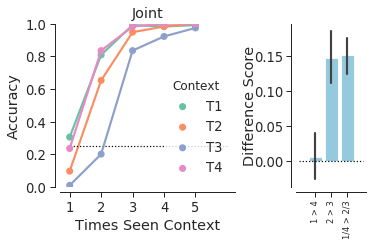

In [10]:
plot_test("Joint")

T1/4 vs T2/3: M=0.13, t(115)=11.944, p=8.08e-22
T2 vs T3: M=-0.04, t(115)=-2.3569, p=0.0201
T1 vs T4: M=0.238, t(115)=13.389, p=3.86e-25


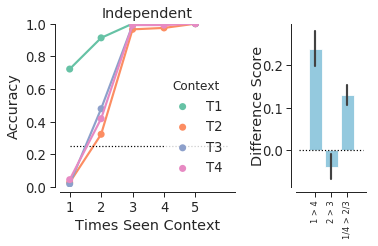

In [11]:
plot_test("Independent")

T1/4 vs T2/3: M=0.13, t(115)=11, p=1.28e-19
T2 vs T3: M=0.0191, t(115)=0.97589, p=0.331
T1 vs T4: M=0.144, t(115)=6.5109, p=2.09e-09


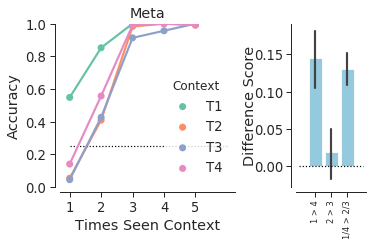

In [12]:
plot_test("Meta")

## Plot the meta-agent weights overtime

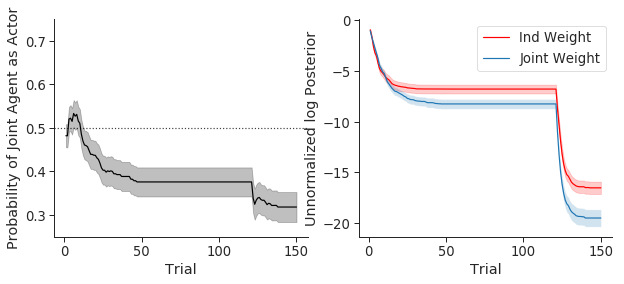

In [13]:
from matplotlib.ticker import NullFormatter


with sns.axes_style('ticks'):

    df0 = results[(results['Steps Taken']==1) & 
                  (results['Model'] == 'Meta')
                 ].copy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    x = range(1, int(df0['Trial Number'].max()) + 2)
    y = df0.groupby('Trial Number')['Joint Probability'].mean()
    y_err = df0.groupby('Trial Number')['Joint Probability'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'k-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.25, color='k')
    ax.set_ylabel('Probability of Joint Agent as Actor')
    ax.set_xlabel('Trial')
    xlb, xub = ax.get_xlim()
    ax.plot([xlb, xub], [0.5, 0.5], 'k:', alpha=0.75)
    ax.set_xlim(xlb, xub)
    ax.set_ylim([0.25, 0.75])

    ax = axes[1]
    y = df0.groupby('Trial Number')['Ind Weight'].mean()
    y_err = df0.groupby('Trial Number')['Ind Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'r-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2, color='r')

    y = df0.groupby('Trial Number')['Joint Weight'].mean()
    y_err = df0.groupby('Trial Number')['Joint Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, '-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)
    plt.legend(loc='best')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Unnormalized log Posterior')    
    ax.set_xlim(xlb, xub)

    plt.subplots_adjust(hspace=0.3)
    sns.despine()